# Visualising model spuriosity using SemScore

This notebook demonstrates how to visualise and quantify model spuriosity. as defined by unintended correlations between a model’s focus regions and irrelevant semantic regions, through SemScore's Semantic Spuriosity Score (SSS) metric. The some of the configurations that users can use to tune the SSS will also be demonstrated.

## Import dependencies

In [ ]:
import sys
import cv2
import json
import timm
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM

sys.path.append('../processing')
from constants import IMAGENET_CLASSES
from processing_utils import create_selected_semantic_mask, semantic_spuriosity_score, make_reshape_transform, select_target_layer

/home/ec2-user/miniconda/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define helper functions to obtain sample info


Model-related

- Extract confidence
- Predict class

Segmentation-related

- Load and align label mappings between ImageNet-1k and ImageNet-S segmentation categories.
- Map mask IDs


In [ ]:
def get_confidence_and_class(outputs):
    probs = F.softmax(outputs, dim=1) # shape: [1, 1000]

    # Get top prediction confidence and class index
    confidence, predicted_class = torch.max(probs, dim=1)

    return predicted_class.item(), f'{confidence.item():.4f}'

def get_predictions(image_path, model, model_settings, device):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    to_tensor = transforms.ToTensor()
    sample_image = to_tensor(image)

    rgb_img = sample_image.permute(1, 2, 0).numpy()
    rgb_img = cv2.resize(rgb_img, (model_settings['image_size'], model_settings['image_size']))
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

    outputs = model(input_tensor)
    pred_index , conf = get_confidence_and_class(outputs)
    print(f"Predicted class index: {pred_index}. Prediction confidence: {conf}.")

    return input_tensor, pred_index, conf

def load_class_label_mapping(model_label_mapping_json, segment_label_mapping_json):
    # Access metadata from ImageNet1k dataset
    with open(model_label_mapping_json, 'r') as file:
        class_object_key = json.load(file)
        
    with open(segment_label_mapping_json, 'r') as file:
        segment_label_mapping = json.load(file)
    
    class_index_key = {int(k): str(v) for k, v in segment_label_mapping.items()}
    
    # Add 1 to account for background
    mask_mapping = {k: class_object_key[v]['id'] + 1 for k, v in class_index_key.items()}

    keys = list(map(int, segment_label_mapping.keys()))
    range_of_class_id_in_seg_dataset = {
        'lower': min(keys),
        'upper': max(keys)
    }
    
    return mask_mapping, range_of_class_id_in_seg_dataset

def map_sample_mask_id(sample_mask, mask_mapping, range_of_class_id_in_seg_dataset):
    # Get mask for values in range of the class IDs of the segmentation masks
    boolean_mask = (sample_mask >= range_of_class_id_in_seg_dataset['lower']) & (sample_mask <= range_of_class_id_in_seg_dataset['upper'])

    # Use vectorized lookup and map the class IDs to the correct class IDs in ImageNet1k
    sample_mask[boolean_mask] = np.vectorize(mask_mapping.get)(sample_mask[boolean_mask])
    return sample_mask

def get_sample_info(segmentation_path, mask_mapping, range_of_class_id_in_seg_dataset):
    sample_masks = np.array(cv2.cvtColor(cv2.imread(segmentation_path), cv2.COLOR_BGR2RGB))

    # The image annotation (eg. an image in validation-segmentation) is stored in the png form with RGB channels
    # The class ID is obtained by applying the following formula on the segmentation mask: R + G * 256
    # Refer to https://github.com/LUSSeg/ImageNet-S?tab=readme-ov-file#qa for further clarification

    sample_masks = sample_masks[:, :, 1] * 256 + sample_masks[:, :, 0]
    
    # Class IDs obtained from segmentation masks have to be converted to their respective IDs from ImageNet1k
    sample_masks = map_sample_mask_id(sample_masks, mask_mapping, range_of_class_id_in_seg_dataset)

    sample_class_ids = [sample_model_id - 1 for sample_model_id in np.unique(sample_masks) if sample_model_id != 0]
    sample_class_labels = [IMAGENET_CLASSES[sample_model_id] for sample_model_id in sample_class_ids]

    return sample_masks, sample_class_ids, sample_class_labels


## Set up the desired paths

In [3]:
# Input paths for parrot example
rgb_image_dir = '../data/ImageNetVal/val'
rbg_image = 'n01817953/ILSVRC2012_val_00045125.JPEG'
image_path = f'{rgb_image_dir}/{rbg_image}'

segmentation_dir = '../data/ImageNet-S/ImageNetS919/validation-segmentation'
segmentation_mask = 'n01817953/ILSVRC2012_val_00045125.png'
segmentation_path = f'{segmentation_dir}/{segmentation_mask}'

sss_visualisation_output_path = 'sss_visualisation_african_grey.png'

# Set up paths for segmentation data and map index from ImageNetS to appropriate ImageNet classes
data_dir = '../data'
model_label_mapping_json = f'{data_dir}/ImageNetVal/map_clsloc_sort.json'
segment_label_mapping_json = f'{data_dir}/ImageNetVal/ImageNetS_categories_im919_sort.json'

mask_mapping, range_of_class_id_in_seg_dataset = load_class_label_mapping(model_label_mapping_json, segment_label_mapping_json)

## Set configurations and get model predictions

Configurations for the toolkit can be set up here, including various methods of smoothing the saliency maps for specific CAM methods, minimum SSS threshold or confidence, and if hard thresholding is desired

In [4]:
# Set up configurations
with open("../processing/model_config/image_classification_config.yaml", "r") as f:
    all_model_settings = yaml.safe_load(f)

device = 'cuda'
eigen_smooth = None
aug_smooth = None
sss_threshold = 0.6
hard_threshold = False
min_confidence = 0.04
filter_coco_stuff = False

# Select desired model for analysis
model_name = "hiera_base"
model_settings = all_model_settings[model_name]

# Reshape input tensors to fit model's input shape
data_reshape_and_transform = make_reshape_transform(model_settings['height'], model_settings['width'], hierarchical=model_settings['hierarchical'])

# Load model
if model_settings['loader'] == 'torchhub':
    model = torch.hub.load(model_settings['repo'], model_settings['model'], pretrained=True).to(torch.device(device)).eval()
else:
    model = timm.create_model(model_settings['model'], pretrained=True).to(torch.device(device)).eval()
    
# Determine target layer based on model settings
target_layers = select_target_layer(model, model_settings['target_layer'])

# Get predictions
input_tensor, pred_index, conf = get_predictions(image_path, model, model_settings, device)

Using hierarchical reshape transform
Predicted class index: 87. Prediction confidence: 0.7563.


## Load the desired sample

In [5]:
# Load semantic segmentation maps
sample_masks, sample_class_ids, sample_class_labels = get_sample_info(segmentation_path, mask_mapping, range_of_class_id_in_seg_dataset)

# Visualise segmentation outputs
print('Shape of sample mask: ', sample_masks.shape)
print('Class IDs present in segmentation mask: ', sample_class_ids)
print('Labels present in segmentation mask: ', sample_class_labels)

Shape of sample mask:  (398, 500)
Class IDs present in segmentation mask:  [87]
Labels present in segmentation mask:  ['grey parrot']


## Obtain semantic mask for "Grey Parrot" using class ID "87"

In [6]:
# Select index of the class of interest from the model output
model_output_id = 87 
desired_class = sample_class_labels[sample_class_ids.index(model_output_id)]

# Modify model output class index to desired class index used for segmentation mask
class_id = int(model_output_id + 1) 
semantic_mask = create_selected_semantic_mask(sample_masks, [class_id]).astype(np.uint8)

## Select saliency method to obtain saliency map for "Grey Parrot" 

Choose the desired saliency methods for the task, in this case image classification using CAM methods.

In [7]:
methods = {
    "gradcam": GradCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
}

# Input desired saliency method
method = 'scorecam'    

if method == "ablationcam":    
    cam = methods[method](
        model=model,
        target_layers=target_layers,
        reshape_transform=data_reshape_and_transform,
        ablation_layer=AblationLayerVit()
    )

else:
    cam = methods[method](        
        model=model,
        target_layers=target_layers,
        reshape_transform=data_reshape_and_transform
    )
    
grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=[ClassifierOutputTarget(model_output_id)],
    eigen_smooth=eigen_smooth,
    aug_smooth=aug_smooth
)

grayscale_cam = grayscale_cam[0, :]

100%|██████████| 56/56 [00:08<00:00,  6.49it/s]


## Calculate SSS and visualise the segmentation mask and saliency map

In [8]:
# Calculate SSS
semantic_mask = cv2.resize(semantic_mask, (model_settings['image_size'], model_settings['image_size']))
sss = semantic_spuriosity_score(
    saliency_map=grayscale_cam,
    semantic_mask=semantic_mask,
    threshold=sss_threshold,
    hard_threshold=hard_threshold
)
print(f'SSS: {sss:.4f}')


SSS: 0.0212


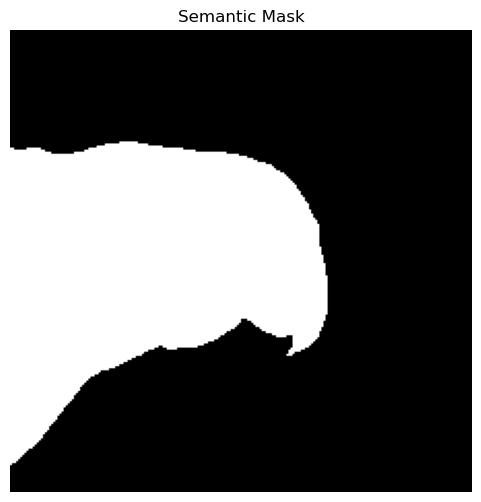

Semantic segmentation mask shape:  (224, 224, 3)


In [ ]:
# Load and display semantic mask 
semantic_mask_rgb = cv2.cvtColor(semantic_mask, cv2.COLOR_BGR2RGB) * 255

plt.figure(figsize=(6, 6))
plt.imshow(semantic_mask_rgb)
plt.axis('off')  # Hide axes
plt.title("Semantic Mask")
plt.show()

print(f'Semantic segmentation mask shape: {semantic_mask_rgb.shape}')

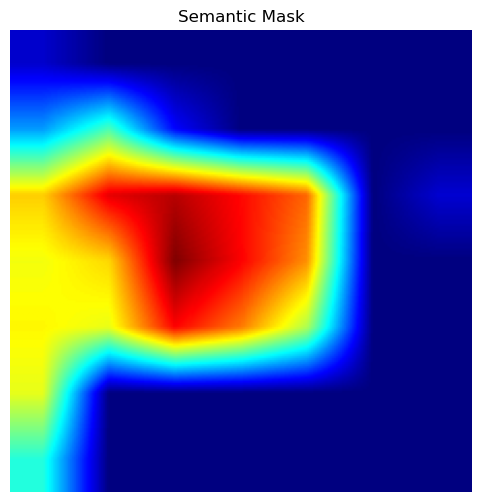

In [10]:
# Load and display saliency map 
grayscale_cam_mask = cv2.cvtColor(grayscale_cam, cv2.COLOR_BGR2RGB)

# Convert to heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam_mask), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255

plt.figure(figsize=(6, 6))
plt.imshow(heatmap)
plt.axis('off')  # Hide axes
plt.title("Semantic Mask")
plt.show()

## Visualise the final output of saliency map over the semantic segmentation mask 

By overlaying the ground-truth segmentation mask of the target class onto the saliency map, we can visualize the correspondence between model focus and true object regions, providing insight into how the Semantic Spuriosity Score (SSS) is computed.

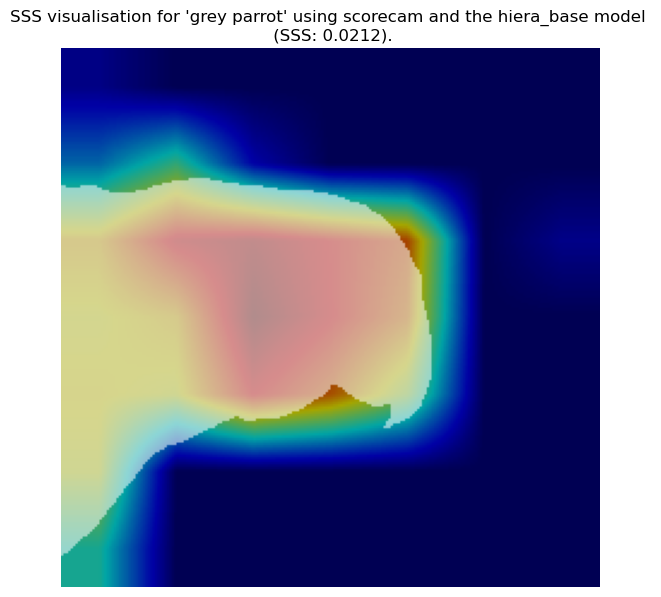

In [ ]:
alpha = 0.55 # transparency for white mask overlay
base_scale = 0.65 # scale to dim CAM base (0=black, 1=full brightness)

# Create a white mask of same shape as semantic mask 
white_mask = np.ones_like(semantic_mask_rgb, dtype=np.float32) * 255

# Convert CAM to heatmap RGB
cam_heatmap = cv2.applyColorMap(
    (grayscale_cam_mask * 255).astype(np.uint8),
    cv2.COLORMAP_JET
)
cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB).astype(np.float32)

# Dim the CAM base to make overlay more visible
cam_base = cam_heatmap * base_scale
cam_base = np.clip(cam_base, 0, 255)

# Create boolean mask where segmentation exists 
if semantic_mask_rgb.ndim == 2:
    seg_mask_bool = semantic_mask_rgb > 0
else:
    seg_mask_bool = np.any(semantic_mask_rgb > 0, axis=-1)  # HxW

seg_mask_bool = seg_mask_bool[..., None]  # shape HxWx1 for broadcasting

# Start with dimmed CAM as base 
blended = cam_base.copy()

# Overlay white mask only where segmentation exists 
blended[seg_mask_bool[..., 0]] = cv2.addWeighted(
    cam_base[seg_mask_bool[..., 0]],
    1 - alpha,
    white_mask[seg_mask_bool[..., 0]],
    alpha,
    0
)

# Clip and convert to uint8 
blended = np.clip(blended, 0, 255).astype(np.uint8)

# Display figure
plt.figure(figsize=(7, 7))
plt.imshow(blended)
plt.axis('off')
plt.title(f"SSS visualisation for '{desired_class}' using {method} and the {model_name} model \n (SSS: {sss:.4f}).")
plt.show()

In [12]:
plt.imsave(sss_visualisation_output_path, blended)
print(f"Saved blended image to: {sss_visualisation_output_path}")

Saved blended image to: sss_visualisation_african_grey.png
